# Flowers Recognition

**Context :** 
This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

**Content :**
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

**Predicting the flower from given classes :** 
'daisy', 'dandelion', 'rose', 'sunflower', 'tulip'

**Data :** [Flowers Recognition Dataset](https://www.kaggle.com/alxmamaev/flowers-recognition)



## Getting our data ready 
Downloading the dataset from Kaggle with the Kaggle API and getting it ready to train our model and also splitting the data into train and test splits.

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d582727d-c895-280a-efd4-93fa83f4f1e8)


In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alxmamaev/flowers-recognition

 90% 203M/225M [00:00<00:00, 208MB/s]
100% 225M/225M [00:01<00:00, 211MB/s]


In [ ]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2021-07-19 06:25:06--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2021-07-19 06:25:06 (88.3 MB/s) - ‘helper_functions.py’ saved [10139/10139]



## Importing Dependancies

In [ ]:
# Importing Dependancies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from helper_functions import unzip_data, walk_through_dir, make_confusion_matrix, plot_loss_curves, compare_historys

In [ ]:
# Unzipping the data
unzip_data("/content/flowers-recognition.zip")

In [ ]:
# deleting the zip file
!rm flowers-recognition.zip

In [ ]:
# Exploring the files in the dataset
walk_through_dir("/content/flowers")

There are 5 directories and 0 images in '/content/flowers'.
There are 0 directories and 733 images in '/content/flowers/sunflower'.
There are 0 directories and 784 images in '/content/flowers/rose'.
There are 0 directories and 984 images in '/content/flowers/tulip'.
There are 0 directories and 1052 images in '/content/flowers/dandelion'.
There are 0 directories and 764 images in '/content/flowers/daisy'.


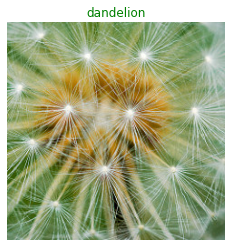

In [ ]:
# Visualizing random images from the dataset
dir_path = "/content/flowers"
labels = os.listdir(dir_path)
random_label = random.choice(labels)
path = os.path.join(dir_path, random_label)
file_path = os.path.join(path, random.choice(os.listdir(path)))

img = plt.imread(file_path)
plt.imshow(img)
plt.title(random_label, color="green")
plt.axis(False);

In [ ]:
os.listdir("flowers")

['sunflower', 'rose', 'tulip', 'dandelion', 'daisy']

In [ ]:
all_file_path = []
for elem in os.listdir(dir_path):
  path = os.path.join(dir_path, elem)
  for fname in os.listdir(path):
    img_path = os.path.join(path, fname)
    all_file_path.append(img_path)

all_file_path[:10]

['/content/flowers/sunflower/9610374042_bb16cded3d.jpg',
 '/content/flowers/sunflower/22183521655_56221bf2a4_n.jpg',
 '/content/flowers/sunflower/2823659190_afdabee45c.jpg',
 '/content/flowers/sunflower/20183028616_beb937e75c_m.jpg',
 '/content/flowers/sunflower/29972905_4cc537ff4b_n.jpg',
 '/content/flowers/sunflower/15493195788_60530f2398_m.jpg',
 '/content/flowers/sunflower/19453165201_2aa747e0bf.jpg',
 '/content/flowers/sunflower/200557979_a16112aac1_n.jpg',
 '/content/flowers/sunflower/3912497870_a2f91c3a65_n.jpg',
 '/content/flowers/sunflower/8929213942_5544191250_n.jpg']

In [ ]:
len(all_file_path)

4317

In [ ]:
# Function for image preprocessing
IMG_SIZE = (224, 224)

def load_and_prep(filepath, normalize=False):
  """
  Image preprocessing, accepts file path and returns
  normalized image.
  """
  # Read the image file
  img = tf.io.read_file(filepath)
  # Converting into tensors
  img = tf.io.decode_image(img)
  # resize image
  img = tf.image.resize(img, IMG_SIZE)
  # Normalizing the image
  if normalize:
    img = img/255.

  return img

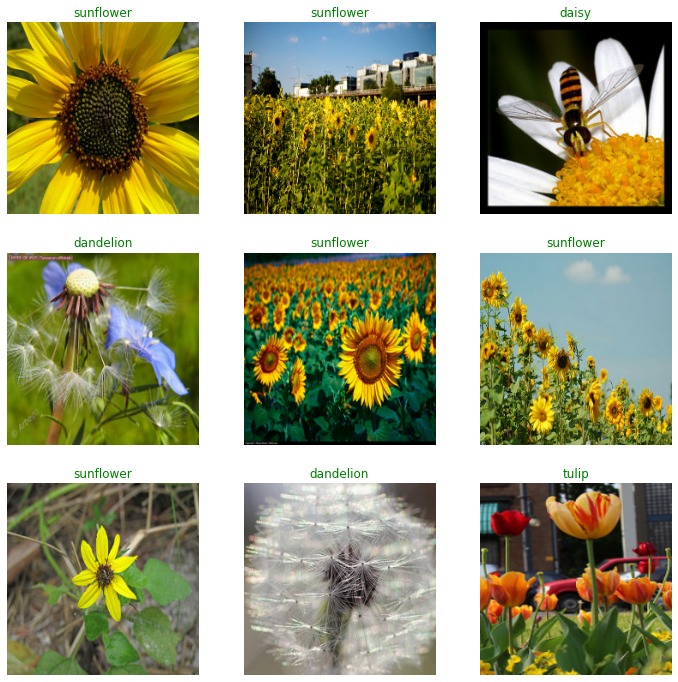

In [ ]:
# Plotting multiple random images
plt.figure(figsize=(12, 12))
for i in range(9):
  random_img_path = random.choice(all_file_path)
  random_label = random_img_path.split("/")[3]
  img = load_and_prep(random_img_path, normalize=True)

  # Plotting the images
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title(random_label, color="green")
  plt.axis(False);

In [ ]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

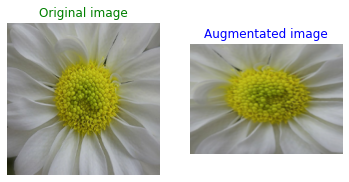

In [ ]:
# Plotting single set of Augmented image
img = load_and_prep(dir_path + "/" + "daisy" + "/" + "100080576_f52e8ee070_n.jpg")
img1 = tf.expand_dims(img, axis=0)
aug_img = data_augmentation(img1)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis(False)
plt.title("Original image", color="green");
plt.subplot(1, 2, 2)
plt.imshow(aug_img[0])
plt.axis(False)
plt.title("Augmentated image", color="blue");

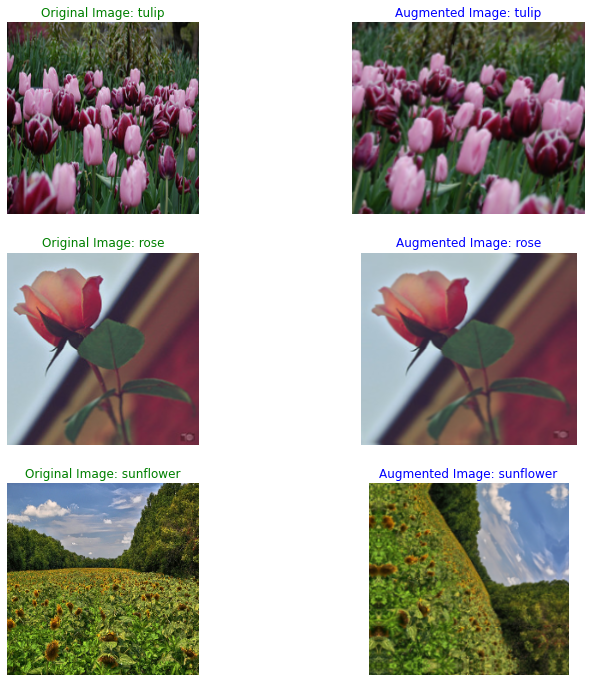

In [ ]:
# Plotting multiple sets of augmented images
plt.figure(figsize=(12, 12))
for i in range(1,7):
  # getting images ready
  random_img_path = random.choice(all_file_path)
  random_label = random_img_path.split("/")[3]
  img = load_and_prep(random_img_path)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))

  # Plotting the images
  if i%2:
    plt.subplot(3, 2, i)
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"Original Image: {random_label}", color="green")
    plt.subplot(3, 2, i+1)
    plt.imshow(aug_img[0])
    plt.axis(False)
    plt.title(f"Augmented Image: {random_label}", color="blue");
  

In [ ]:
# Train Test split
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

train_data = image_generator.flow_from_directory(directory='/content/flowers',
                                                 subset='training',
                                                 target_size=IMG_SIZE)

test_data = image_generator.flow_from_directory(directory='/content/flowers',
                                                subset='validation',
                                                target_size=IMG_SIZE)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:
len(train_data), len(test_data)

(109, 27)

## Model 1

In [ ]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) 
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data))

Epoch 1/5
109/109 [==============================] - 70s 322ms/step - loss: 0.8168 - accuracy: 0.7206 - val_loss: 0.4429 - val_accuracy: 0.8571
Epoch 2/5
109/109 [==============================] - 26s 238ms/step - loss: 0.4496 - accuracy: 0.8577 - val_loss: 0.4232 - val_accuracy: 0.8438
Epoch 3/5
109/109 [==============================] - 25s 229ms/step - loss: 0.3758 - accuracy: 0.8776 - val_loss: 0.2992 - val_accuracy: 0.9062
Epoch 4/5
109/109 [==============================] - 22s 206ms/step - loss: 0.3373 - accuracy: 0.8907 - val_loss: 0.3258 - val_accuracy: 0.8795
Epoch 5/5
109/109 [==============================] - 22s 196ms/step - loss: 0.3036 - accuracy: 0.8993 - val_loss: 0.2366 - val_accuracy: 0.9152


In [ ]:
model_1.evaluate(test_data)

27/27 [==============================] - 3s 127ms/step - loss: 0.3005 - accuracy: 0.9023


[0.30051082372665405, 0.9023255705833435]

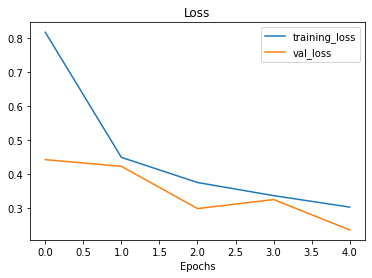

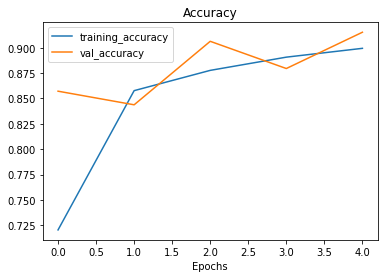

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# fitting the model for another 5 epochs
history_1_2 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data),
                        initial_epoch=history_1.epoch[-1])

Epoch 5/10
109/109 [==============================] - 21s 188ms/step - loss: 0.2893 - accuracy: 0.9060 - val_loss: 0.3138 - val_accuracy: 0.8884
Epoch 6/10
109/109 [==============================] - 19s 171ms/step - loss: 0.2748 - accuracy: 0.9071 - val_loss: 0.2348 - val_accuracy: 0.9286
Epoch 7/10
109/109 [==============================] - 18s 170ms/step - loss: 0.2594 - accuracy: 0.9158 - val_loss: 0.2715 - val_accuracy: 0.9062
Epoch 8/10
109/109 [==============================] - 19s 173ms/step - loss: 0.2514 - accuracy: 0.9164 - val_loss: 0.2532 - val_accuracy: 0.9107
Epoch 9/10
109/109 [==============================] - 19s 178ms/step - loss: 0.2377 - accuracy: 0.9216 - val_loss: 0.2753 - val_accuracy: 0.9018
Epoch 10/10
109/109 [==============================] - 18s 166ms/step - loss: 0.2296 - accuracy: 0.9239 - val_loss: 0.2545 - val_accuracy: 0.9018


In [ ]:
model_1.evaluate(test_data)

27/27 [==============================] - 3s 109ms/step - loss: 0.2766 - accuracy: 0.9035


[0.27659720182418823, 0.9034883975982666]

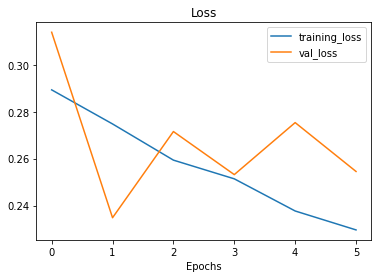

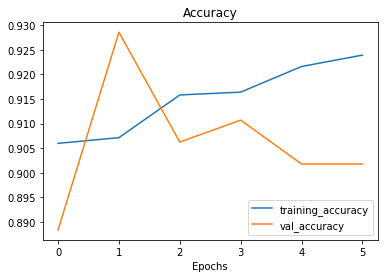

In [ ]:
plot_loss_curves(history_1_2)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 

history_1_fine_tune_1 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=0.25 * len(test_data), 
                                    initial_epoch=history_1.epoch[-1])

Epoch 5/10
109/109 [==============================] - 26s 181ms/step - loss: 0.2146 - accuracy: 0.9300 - val_loss: 0.2140 - val_accuracy: 0.9330
Epoch 6/10
109/109 [==============================] - 18s 160ms/step - loss: 0.1867 - accuracy: 0.9369 - val_loss: 0.3628 - val_accuracy: 0.9062
Epoch 7/10
109/109 [==============================] - 18s 161ms/step - loss: 0.1536 - accuracy: 0.9517 - val_loss: 0.2480 - val_accuracy: 0.9062
Epoch 8/10
109/109 [==============================] - 18s 163ms/step - loss: 0.1360 - accuracy: 0.9546 - val_loss: 0.1920 - val_accuracy: 0.9241
Epoch 9/10
109/109 [==============================] - 17s 159ms/step - loss: 0.1307 - accuracy: 0.9578 - val_loss: 0.2601 - val_accuracy: 0.8973
Epoch 10/10
109/109 [==============================] - 16s 145ms/step - loss: 0.1115 - accuracy: 0.9647 - val_loss: 0.2713 - val_accuracy: 0.9241


In [ ]:
model_1.evaluate(test_data)

27/27 [==============================] - 3s 107ms/step - loss: 0.2522 - accuracy: 0.9198


[0.2522103786468506, 0.919767439365387]

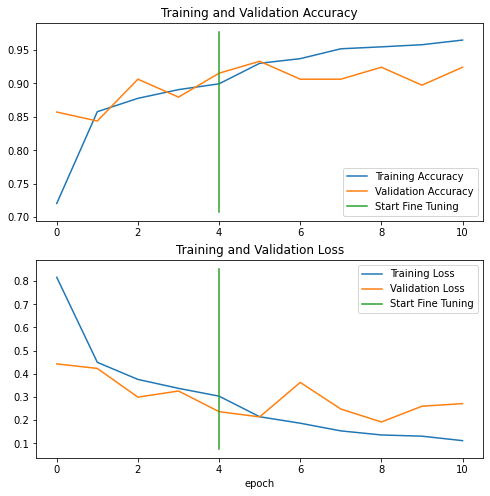

In [ ]:
compare_historys(history_1, history_1_fine_tune_1, 5)

In [ ]:
model_1.save("Efficientnet_1")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: Efficientnet_1/assets


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-5),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 15

history_1_fine_tune_2 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=0.25 * len(test_data), 
                                    initial_epoch=history_1_fine_tune_1.epoch[-1])

Epoch 10/15
109/109 [==============================] - 25s 171ms/step - loss: 0.0992 - accuracy: 0.9690 - val_loss: 0.2265 - val_accuracy: 0.9196
Epoch 11/15
109/109 [==============================] - 17s 153ms/step - loss: 0.0899 - accuracy: 0.9754 - val_loss: 0.2738 - val_accuracy: 0.9241
Epoch 12/15
109/109 [==============================] - 17s 153ms/step - loss: 0.0937 - accuracy: 0.9708 - val_loss: 0.3155 - val_accuracy: 0.9018
Epoch 13/15
109/109 [==============================] - 18s 160ms/step - loss: 0.0848 - accuracy: 0.9751 - val_loss: 0.2197 - val_accuracy: 0.9286
Epoch 14/15
109/109 [==============================] - 16s 150ms/step - loss: 0.0816 - accuracy: 0.9786 - val_loss: 0.2920 - val_accuracy: 0.9152
Epoch 15/15
109/109 [==============================] - 16s 149ms/step - loss: 0.0837 - accuracy: 0.9783 - val_loss: 0.2066 - val_accuracy: 0.9286


In [ ]:
model_1.evaluate(test_data)

27/27 [==============================] - 3s 116ms/step - loss: 0.2577 - accuracy: 0.9209


[0.25773492455482483, 0.9209302067756653]

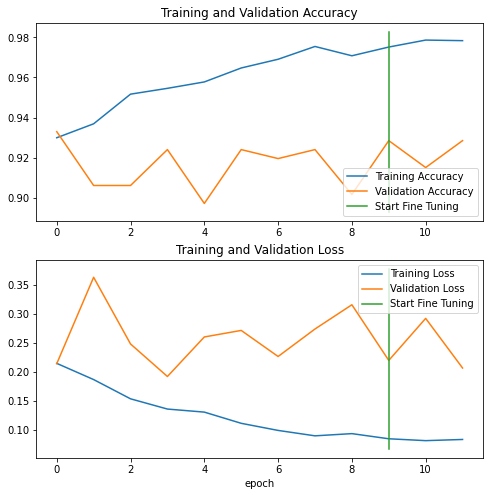

In [ ]:
compare_historys(history_1_fine_tune_1, history_1_fine_tune_2, 10)

In [ ]:
model_1.save("Efficientnet_2")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: Efficientnet_2/assets


## Model 2

In [ ]:
# Setting up base model
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Setting up input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) 
model_2 = tf.keras.Model(inputs, outputs)

# compiling the model
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data))

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/5
109/109 [==============================] - 81s 712ms/step - loss: 0.8014 - accuracy: 0.7090 - val_loss: 0.4933 - val_accuracy: 0.8080
Epoch 2/5
109/109 [==============================] - 48s 435ms/step - loss: 0.4851 - accuracy: 0.8227 - val_loss: 0.5403 - val_accuracy: 0.8125
Epoch 3/5
109/109 [==============================] - 40s 365ms/step - loss: 0.4187 - accuracy: 0.8490 - val_loss: 0.3526 - val_accuracy: 0.9018
Epoch 4/5
109/109 [==============================] - 40s 365ms/step - loss: 0.4280 - accuracy: 0.8496 - val_loss: 0.3896 - val_accuracy: 0.8750
Epoch 5/5
109/109 [==============================] - 29s 265ms/step - loss: 0.3755 - accuracy: 0.8707 - val_loss: 0.3707 - val_accuracy: 0.8750


In [ ]:
model_2.evaluate(test_data)

27/27 [==============================] - 4s 158ms/step - loss: 0.4066 - accuracy: 0.8593


[0.4065916836261749, 0.8593023419380188]

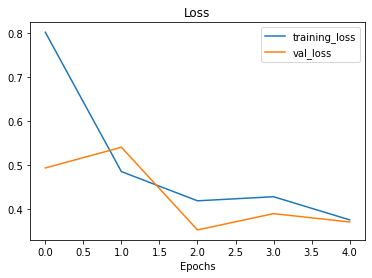

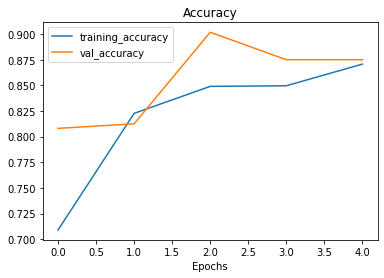

In [ ]:
plot_loss_curves(history_2)

In [ ]:
# fit the model
history_2_2 = model_2.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data),
                        initial_epoch=history_2.epoch[-1])

Epoch 5/10
109/109 [==============================] - 28s 253ms/step - loss: 0.3476 - accuracy: 0.8762 - val_loss: 0.4116 - val_accuracy: 0.8750
Epoch 6/10
109/109 [==============================] - 28s 250ms/step - loss: 0.3212 - accuracy: 0.8881 - val_loss: 0.4049 - val_accuracy: 0.8393
Epoch 7/10
109/109 [==============================] - 26s 240ms/step - loss: 0.3159 - accuracy: 0.8863 - val_loss: 0.3621 - val_accuracy: 0.8795
Epoch 8/10
109/109 [==============================] - 26s 243ms/step - loss: 0.3015 - accuracy: 0.8970 - val_loss: 0.4680 - val_accuracy: 0.8348
Epoch 9/10
109/109 [==============================] - 24s 220ms/step - loss: 0.2931 - accuracy: 0.8938 - val_loss: 0.3828 - val_accuracy: 0.8705
Epoch 10/10
109/109 [==============================] - 22s 204ms/step - loss: 0.2892 - accuracy: 0.8973 - val_loss: 0.4478 - val_accuracy: 0.8661


In [ ]:
model_1.evaluate(test_data)

27/27 [==============================] - 3s 107ms/step - loss: 0.2577 - accuracy: 0.9209


[0.2577349543571472, 0.9209302067756653]

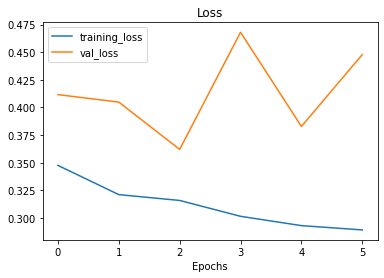

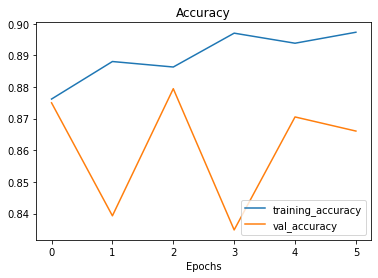

In [ ]:
plot_loss_curves(history_2_2)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_2_fine_tune_1 = model_2.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=0.25 * len(test_data), 
                                    initial_epoch=history_2.epoch[-1])

Epoch 5/10
109/109 [==============================] - 28s 227ms/step - loss: 0.3086 - accuracy: 0.8863 - val_loss: 0.5062 - val_accuracy: 0.8393
Epoch 6/10
109/109 [==============================] - 23s 210ms/step - loss: 0.2704 - accuracy: 0.9016 - val_loss: 0.5823 - val_accuracy: 0.8527
Epoch 7/10
109/109 [==============================] - 22s 202ms/step - loss: 0.2482 - accuracy: 0.9135 - val_loss: 0.3257 - val_accuracy: 0.8973
Epoch 8/10
109/109 [==============================] - 21s 190ms/step - loss: 0.2318 - accuracy: 0.9190 - val_loss: 0.4570 - val_accuracy: 0.8661
Epoch 9/10
109/109 [==============================] - 21s 191ms/step - loss: 0.2248 - accuracy: 0.9233 - val_loss: 0.4691 - val_accuracy: 0.8259
Epoch 10/10
109/109 [==============================] - 20s 186ms/step - loss: 0.2268 - accuracy: 0.9228 - val_loss: 0.4534 - val_accuracy: 0.8616


In [ ]:
model_2.evaluate(test_data)

27/27 [==============================] - 3s 114ms/step - loss: 0.4236 - accuracy: 0.8709


[0.423577219247818, 0.8709302544593811]

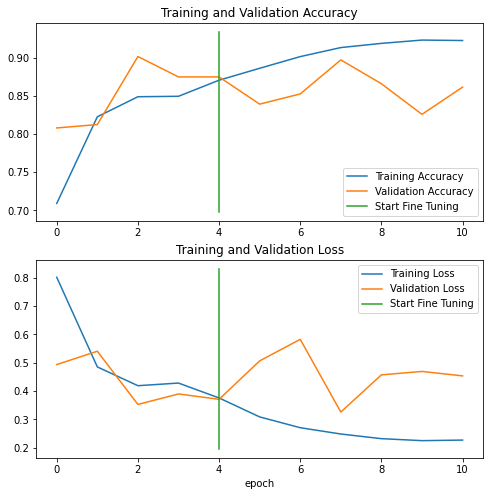

In [ ]:
compare_historys(history_2, history_2_fine_tune_1, 5)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile model with lower learning rate
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-5),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 15

history_2_fine_tune_2 = model_2.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=0.25 * len(test_data), 
                                    initial_epoch=history_2_fine_tune_1.epoch[-1])

Epoch 10/15
109/109 [==============================] - 31s 253ms/step - loss: 0.1841 - accuracy: 0.9338 - val_loss: 0.2980 - val_accuracy: 0.8884
Epoch 11/15
109/109 [==============================] - 22s 203ms/step - loss: 0.1624 - accuracy: 0.9404 - val_loss: 0.3192 - val_accuracy: 0.9062
Epoch 12/15
109/109 [==============================] - 22s 198ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.4833 - val_accuracy: 0.8616
Epoch 13/15
109/109 [==============================] - 22s 198ms/step - loss: 0.1272 - accuracy: 0.9546 - val_loss: 0.3998 - val_accuracy: 0.9018
Epoch 14/15
109/109 [==============================] - 22s 199ms/step - loss: 0.1190 - accuracy: 0.9520 - val_loss: 0.4853 - val_accuracy: 0.8839
Epoch 15/15
109/109 [==============================] - 21s 194ms/step - loss: 0.1151 - accuracy: 0.9581 - val_loss: 0.2554 - val_accuracy: 0.9152


In [ ]:
model_2.evaluate(test_data)

27/27 [==============================] - 3s 115ms/step - loss: 0.4763 - accuracy: 0.8837


[0.4763319194316864, 0.8837209343910217]

In [ ]:
model_2.save("ResNet50V2")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ResNet50V2/assets


In [ ]:
test_paths = np.array(test_data.filepaths)

In [ ]:
test_paths[:10]

array(['/content/flowers/daisy/100080576_f52e8ee070_n.jpg',
       '/content/flowers/daisy/10140303196_b88d3d6cec.jpg',
       '/content/flowers/daisy/10172379554_b296050f82_n.jpg',
       '/content/flowers/daisy/10172567486_2748826a8b.jpg',
       '/content/flowers/daisy/10172636503_21bededa75_n.jpg',
       '/content/flowers/daisy/102841525_bd6628ae3c.jpg',
       '/content/flowers/daisy/10300722094_28fa978807_n.jpg',
       '/content/flowers/daisy/1031799732_e7f4008c03.jpg',
       '/content/flowers/daisy/10391248763_1d16681106_n.jpg',
       '/content/flowers/daisy/10437754174_22ec990b77_m.jpg'],
      dtype='<U55')

In [ ]:
test_labels = []
for elem in test_paths:
  test_labels.append(elem.split("/")[3])

In [ ]:
test_labels[:10]

['daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy',
 'daisy']

In [ ]:
df = pd.DataFrame({"filename" : test_paths,
                   "label": test_labels})

In [ ]:
df.head()

,filename,label
0,/content/flowers/daisy/100080576_f52e8ee070_n.jpg,daisy
1,/content/flowers/daisy/10140303196_b88d3d6cec.jpg,daisy
2,/content/flowers/daisy/10172379554_b296050f82_...,daisy
3,/content/flowers/daisy/10172567486_2748826a8b.jpg,daisy
4,/content/flowers/daisy/10172636503_21bededa75_...,daisy


In [ ]:
len(df)

860

In [ ]:
classes = []
for elem in test_data.class_indices.keys():
  classes.append(elem)

classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
label_val = []
for elem in test_paths:
  for cl in range(5):
    if elem.split("/")[3] == classes[cl]:
      label_val.append(cl)

In [ ]:
df = pd.DataFrame({"filename" : test_paths,
                   "label": test_labels,
                   "label_val": label_val})

In [ ]:
df.head()

,filename,label,label_val
0,/content/flowers/daisy/100080576_f52e8ee070_n.jpg,daisy,0
1,/content/flowers/daisy/10140303196_b88d3d6cec.jpg,daisy,0
2,/content/flowers/daisy/10172379554_b296050f82_...,daisy,0
3,/content/flowers/daisy/10172567486_2748826a8b.jpg,daisy,0
4,/content/flowers/daisy/10172636503_21bededa75_...,daisy,0


In [ ]:
check_datagen = ImageDataGenerator()

In [ ]:
check_data = check_datagen.flow_from_dataframe(df, 
                                               x_col='filename', 
                                               y_col='label',
                                               shuffle=False)

Found 860 validated image filenames belonging to 5 classes.


In [ ]:
pred_prob = model_1.predict(check_data)
pred_prob

array([[9.8760623e-01, 8.0420828e-04, 3.7879522e-03, 6.5765358e-03,
        1.2249561e-03],
       [9.9896097e-01, 4.7422163e-05, 5.1494826e-05, 2.3665549e-05,
        9.1647520e-04],
       [9.8887038e-01, 5.6195455e-03, 9.4136603e-06, 5.0732307e-03,
        4.2746641e-04],
       ...,
       [6.6267401e-02, 5.2527142e-01, 2.1226208e-01, 1.9781386e-02,
        1.7641771e-01],
       [8.3674777e-08, 2.1855937e-09, 4.5244928e-04, 8.9098347e-12,
        9.9954742e-01],
       [8.6181180e-06, 6.2154211e-09, 6.5834805e-02, 5.3237077e-09,
        9.3415654e-01]], dtype=float32)

In [ ]:
y_pred = pred_prob.argmax(axis=1)
y_pred[:50]

array([0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
y_true = np.array(label_val)
y_true[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

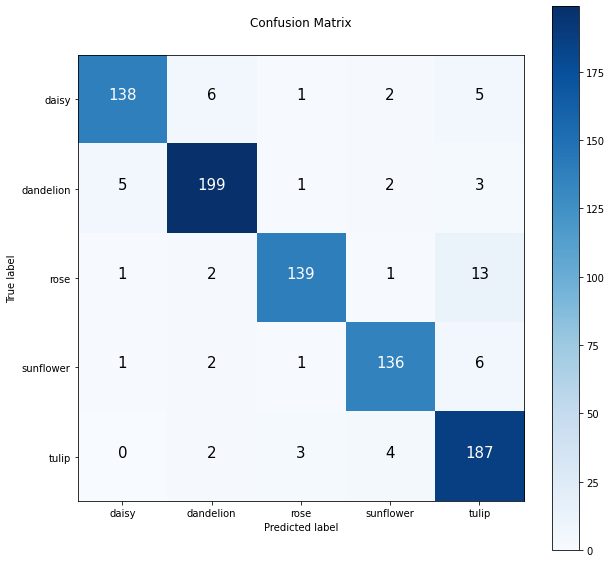

In [ ]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=classes,)

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       152
           1       0.94      0.95      0.95       210
           2       0.96      0.89      0.92       156
           3       0.94      0.93      0.93       146
           4       0.87      0.95      0.91       196

    accuracy                           0.93       860
   macro avg       0.93      0.93      0.93       860
weighted avg       0.93      0.93      0.93       860



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9292929292929293,
  'precision': 0.9517241379310345,
  'recall': 0.9078947368421053,
  'support': 152},
 '1': {'f1-score': 0.9453681710213775,
  'precision': 0.943127962085308,
  'recall': 0.9476190476190476,
  'support': 210},
 '2': {'f1-score': 0.9235880398671097,
  'precision': 0.9586206896551724,
  'recall': 0.8910256410256411,
  'support': 156},
 '3': {'f1-score': 0.9347079037800687,
  'precision': 0.9379310344827586,
  'recall': 0.9315068493150684,
  'support': 146},
 '4': {'f1-score': 0.9121951219512195,
  'precision': 0.8738317757009346,
  'recall': 0.9540816326530612,
  'support': 196},
 'accuracy': 0.9290697674418604,
 'macro avg': {'f1-score': 0.9290304331825409,
  'precision': 0.9330471199710416,
  'recall': 0.9264255814909846,
  'support': 860},
 'weighted avg': {'f1-score': 0.9292060153960612,
  'precision': 0.9307822414668661,
  'recall': 0.9290697674418604,
  'support': 860}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[classes[int(k)]] = v["f1-score"]
class_f1_scores

{'daisy': 0.9292929292929293,
 'dandelion': 0.9453681710213775,
 'rose': 0.9235880398671097,
 'sunflower': 0.9347079037800687,
 'tulip': 0.9121951219512195}

In [ ]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
1,dandelion,0.945368
3,sunflower,0.934708
0,daisy,0.929293
2,rose,0.923588
4,tulip,0.912195


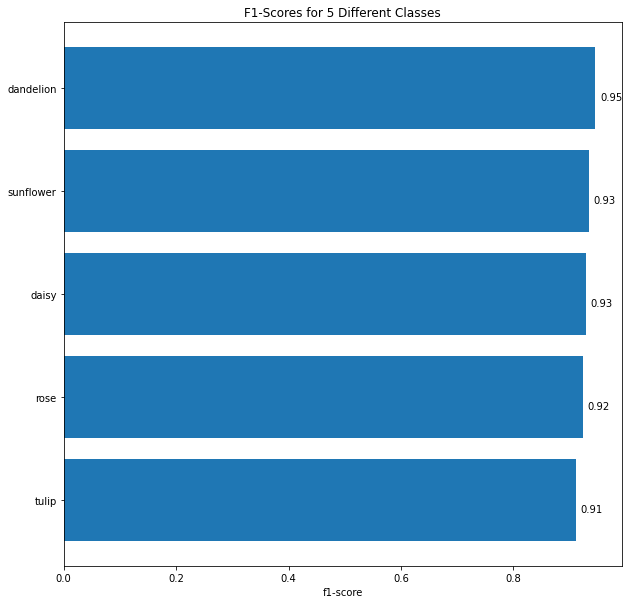

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 5 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

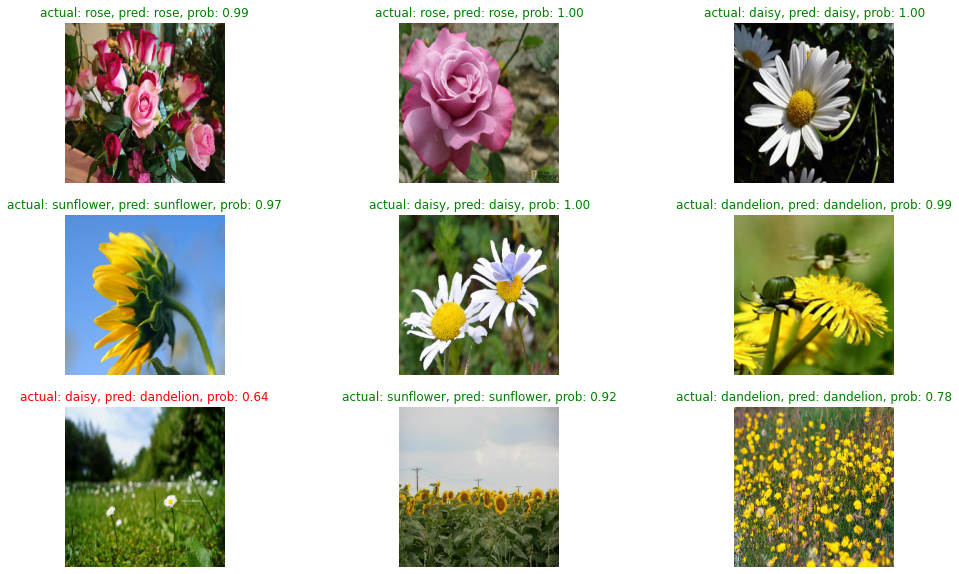

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(9):
  # Choose a random image from a random class 
  filepath = random.choice(test_paths)
  class_name = filepath.split("/")[3]

  # Load the image and make predictions
  img = load_and_prep(filepath) 
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = classes[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
df_pred = pd.DataFrame({"filename" : test_paths,
                         "label": test_labels,
                         "label_val": label_val,
                         "pred": y_pred})

In [ ]:
df_pred.head()

,filename,label,label_val,pred
0,/content/flowers/daisy/100080576_f52e8ee070_n.jpg,daisy,0,0
1,/content/flowers/daisy/10140303196_b88d3d6cec.jpg,daisy,0,0
2,/content/flowers/daisy/10172379554_b296050f82_...,daisy,0,0
3,/content/flowers/daisy/10172567486_2748826a8b.jpg,daisy,0,0
4,/content/flowers/daisy/10172636503_21bededa75_...,daisy,0,0


In [ ]:
pred_probs = model_1.predict(check_data)
pred_probs

array([[9.8760623e-01, 8.0420828e-04, 3.7879522e-03, 6.5765358e-03,
        1.2249561e-03],
       [9.9896097e-01, 4.7422163e-05, 5.1494826e-05, 2.3665549e-05,
        9.1647520e-04],
       [9.8887038e-01, 5.6195455e-03, 9.4136603e-06, 5.0732307e-03,
        4.2746641e-04],
       ...,
       [6.6267401e-02, 5.2527142e-01, 2.1226208e-01, 1.9781386e-02,
        1.7641771e-01],
       [8.3674777e-08, 2.1855937e-09, 4.5244928e-04, 8.9098347e-12,
        9.9954742e-01],
       [8.6181180e-06, 6.2154211e-09, 6.5834805e-02, 5.3237077e-09,
        9.3415654e-01]], dtype=float32)

In [ ]:
pred_df = pd.DataFrame({"img_path": test_paths,
                        "y_true": y_true,
                        "y_pred": y_pred,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [classes[i] for i in y_true],
                        "y_pred_classname": [classes[i] for i in y_pred]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,/content/flowers/daisy/100080576_f52e8ee070_n.jpg,0,0,0.987606,daisy,daisy
1,/content/flowers/daisy/10140303196_b88d3d6cec.jpg,0,0,0.998961,daisy,daisy
2,/content/flowers/daisy/10172379554_b296050f82_...,0,0,0.988870,daisy,daisy
3,/content/flowers/daisy/10172567486_2748826a8b.jpg,0,0,0.999947,daisy,daisy
4,/content/flowers/daisy/10172636503_21bededa75_...,0,0,0.955864,daisy,daisy


In [ ]:
# check for pred 
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,/content/flowers/daisy/100080576_f52e8ee070_n.jpg,0,0,0.987606,daisy,daisy,True
1,/content/flowers/daisy/10140303196_b88d3d6cec.jpg,0,0,0.998961,daisy,daisy,True
2,/content/flowers/daisy/10172379554_b296050f82_...,0,0,0.988870,daisy,daisy,True
3,/content/flowers/daisy/10172567486_2748826a8b.jpg,0,0,0.999947,daisy,daisy,True
4,/content/flowers/daisy/10172636503_21bededa75_...,0,0,0.955864,daisy,daisy,True


61 images are wrongly predicted

In [ ]:
# Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
192,/content/flowers/dandelion/13386618495_3df1f13...,1,0,0.999892,dandelion,daisy,False
602,/content/flowers/sunflower/15030133005_9728102...,3,4,0.997907,sunflower,tulip,False
413,/content/flowers/rose/14381787252_e8e12e277a_n...,2,4,0.995477,rose,tulip,False
700,/content/flowers/tulip/12557176134_ecbf15885b.jpg,4,2,0.993204,tulip,rose,False
367,/content/flowers/rose/11102341464_508d558dfc_n...,2,4,0.992317,rose,tulip,False
181,/content/flowers/dandelion/12093962485_7c3e9a2...,1,4,0.990789,dandelion,tulip,False
67,/content/flowers/daisy/14088053307_1a13a0bf91_...,0,4,0.981706,daisy,tulip,False
813,/content/flowers/tulip/14067778605_0285b7cc3a.jpg,4,3,0.972259,tulip,sunflower,False
627,/content/flowers/sunflower/15191613243_82ee8e0...,3,4,0.967261,sunflower,tulip,False
501,/content/flowers/rose/16209331331_343c899d38.jpg,2,3,0.960371,rose,sunflower,False


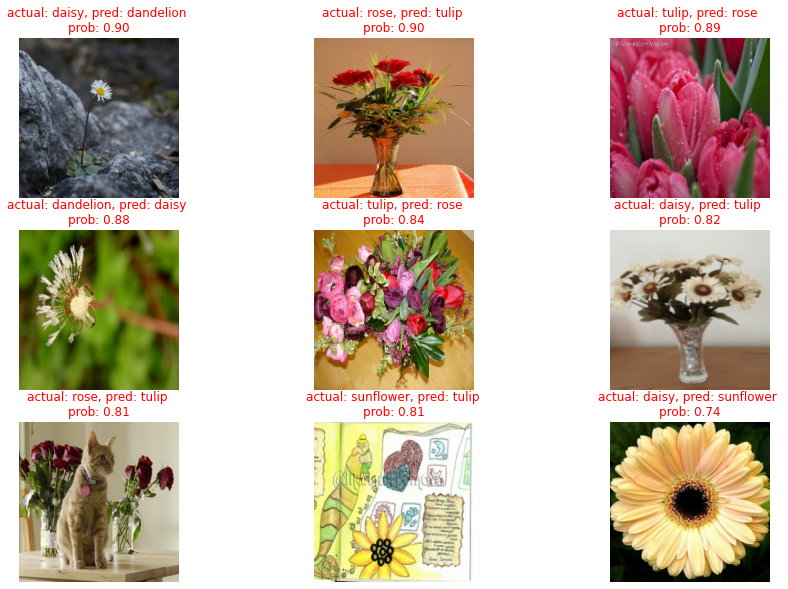

In [ ]:
# Visualize some of the most wrong examples
images_to_view = 9
start_index = 20 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep(row[1], normalize=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}", color="red")
  plt.axis(False)